In [77]:
import pandas as pd
import numpy as np
import json
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Flatten
from keras.models import Model
from keras.initializers import Constant
from sklearn.preprocessing import LabelEncoder
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [25]:
with open ('intents.json', encoding = 'utf8') as f:
    data = json.load(f)

In [27]:
X, y = [], []
for i in data['intents']:
    for j in i['patterns']:
        X.append(j)
        y.append(i['tag'])

In [28]:
X[:10]

['Hi',
 'How are you?',
 'Is anyone there?',
 'Hello',
 'Good day',
 "What's up",
 'how are ya',
 'heyy',
 'whatsup',
 '??? ??? ??']

In [29]:
y[:10]

['greeting',
 'greeting',
 'greeting',
 'greeting',
 'greeting',
 'greeting',
 'greeting',
 'greeting',
 'greeting',
 'greeting']

In [30]:
resp = dict()
for i in data['intents']:
    resp[i['tag']] = i['responses']

In [31]:
resp['greeting']

['Hello!', 'Good to see you again!', 'Hi there, how can I help?']

In [32]:
print('The size of dataset is:', len(X))

The size of dataset is: 405


In [33]:
len(y)

405

In [34]:
X_s, y_s = shuffle(X, y)

In [35]:
df = pd.DataFrame()
df['sentence'] = X_s
df['intent'] = y_s

In [36]:
df.head()

,sentence,intent
0,information on fee,fees
1,Whats there on menu,menu
2,dumb ass,swear
3,hostel fees,hostel
4,admission,admission


In [37]:
df.shape

(405, 2)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  405 non-null    object
 1   intent    405 non-null    object
dtypes: object(2)
memory usage: 6.5+ KB


In [39]:
df.isnull().sum()

sentence    0
intent      0
dtype: int64

In [41]:
print('The Number of classes in the dataset is:', df['intent'].nunique())

The Number of classes in the dataset is: 38


In [42]:
classes = df['intent'].nunique()

In [45]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['sentence'])
seq = tokenizer.texts_to_sequences(df['sentence'])

In [46]:
seq[:10]

[[39, 88, 40],
 [89, 24, 88, 110],
 [161, 162],
 [11, 14],
 [21],
 [3, 1, 2, 111],
 [3, 1, 2, 90],
 [14, 8, 54, 55, 8, 112],
 [32],
 [113, 114]]

In [47]:
maxlen = max([len(i) for i in seq])
maxlen

9

In [48]:
pad_seq = pad_sequences(seq, maxlen = maxlen, padding = 'post')
pad_seq[:10]

array([[ 39,  88,  40,   0,   0,   0,   0,   0,   0],
       [ 89,  24,  88, 110,   0,   0,   0,   0,   0],
       [161, 162,   0,   0,   0,   0,   0,   0,   0],
       [ 11,  14,   0,   0,   0,   0,   0,   0,   0],
       [ 21,   0,   0,   0,   0,   0,   0,   0,   0],
       [  3,   1,   2, 111,   0,   0,   0,   0,   0],
       [  3,   1,   2,  90,   0,   0,   0,   0,   0],
       [ 14,   8,  54,  55,   8, 112,   0,   0,   0],
       [ 32,   0,   0,   0,   0,   0,   0,   0,   0],
       [113, 114,   0,   0,   0,   0,   0,   0,   0]])

In [49]:
vocab_size = len(tokenizer.word_index) + 1

In [50]:
vocab_size

280

In [52]:
glove_file = open('glove.6B.100d.txt', encoding = 'utf-8')
embedding_vector = dict()
for line in glove_file:
    record = line.split()
    word = record[0]
    vector = np.asarray(record[1:], dtype = 'float32')
    embedding_vector[word] = vector
glove_file.close()

In [53]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    vec = embedding_vector.get(word)
    if vec is not None:
        embedding_matrix[index] = vec

In [54]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.54263997,  0.41475999,  1.03219998, ..., -1.29690003,
         0.76217002,  0.46349001],
       [ 0.49314001,  0.14623   , -0.50769001, ...,  0.27783999,
         0.82843   ,  0.54211003],
       ...,
       [-0.64894003,  0.19546001, -0.86852002, ..., -0.91429001,
         0.62915999, -0.42714   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.083012  , -0.74462998,  0.36394   , ...,  0.10641   ,
         0.43051001, -0.036887  ]])

In [62]:
i = Input(shape = (maxlen, ))
x = Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_matrix), trainable = False)(i)
x = Bidirectional(LSTM(15))(x)
x = Flatten()(x)
x = Dense(classes, activation = 'softmax')(x)
model1 = Model(inputs = i, outputs = x)

In [63]:
model1.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [64]:
y = df['intent']

In [65]:
y

0           fees
1           menu
2          swear
3         hostel
4      admission
         ...    
400    principal
401     document
402        ithod
403      canteen
404       number
Name: intent, Length: 405, dtype: object

In [67]:
le = LabelEncoder()
y_le = le.fit_transform(y)

In [68]:
history1 = model1.fit(pad_seq, y_le, epochs = 100)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.0452 - loss: 3.6311
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1599 - loss: 3.5299
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1990 - loss: 3.4438 
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1866 - loss: 3.3633
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2182 - loss: 3.2143
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2587 - loss: 3.0902
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3385 - loss: 2.8548
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3953 - loss: 2.6114
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4701 - loss: 2.4294
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5489 - loss: 2.1149
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5713 - loss: 1.9436
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accurac

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9978 - loss: 0.0563
Epoch 70/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9961 - loss: 0.0563
Epoch 71/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9993 - loss: 0.0527
Epoch 72/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9982 - loss: 0.0553
Epoch 73/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9975 - loss: 0.0467
Epoch 74/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9978 - loss: 0.0504
Epoch 75/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9909 - loss: 0.0512 
Epoch 76/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9935 - loss: 0.0452
Epoch 77/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9996 - loss: 0.0402 
Epoch 78/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9964 - loss: 0.0417 
Epoch 79/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9968 - loss: 0.0463
Epoch 80/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accurac

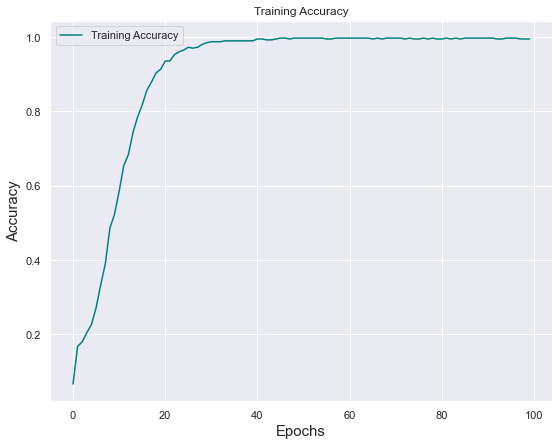

In [78]:
plt.figure(figsize = (9, 7))
plt.plot(history1.history['accuracy'], label = 'Training Accuracy', color = 'teal')
plt.title('Training Accuracy')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.legend()
plt.show()

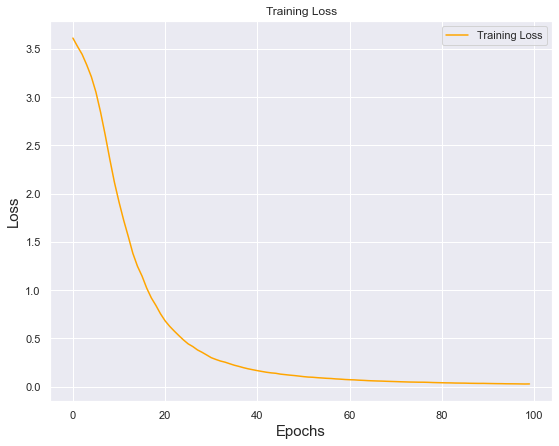

In [79]:
plt.figure(figsize = (9, 7))
plt.plot(history1.history['loss'], label = 'Training Loss', color = 'orange')
plt.title('Training Loss')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend()
plt.show()

In [83]:
while True:
    input_text = input('You: ')
    in_seq = tokenizer.texts_to_sequences([input_text])
    pad_in_seq = pad_sequences(in_seq, maxlen = maxlen, padding = 'post')
    y_pred = le.inverse_transform([np.argmax(model1.predict(pad_in_seq))])[0]
    print(random.choice(resp[y_pred]))
    if y_pred == 'goodbye':
        break

You: hello, how are you?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Good to see you again!
You: i want to know about college timing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
College is open 8am-5pm Monday-Saturday!
You: i want to know about university timing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
College is open 8am-5pm Monday-Saturday!
You: can i have college number
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
You can contact at: NUMBER
You: can i have college courses
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Our university offers Information Technology, computer Engineering, Mechanical engineering,Chemical engineering, Civil engineering and extc Engineering.
You: could you explain about fees
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
For Fee detail visit <a target="_blank" href="LINK"> here</a>
You: give me university location
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
For the various committe in college contact this number: ADD NUMBER
You: where is university
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Our university h